# 공유 자전거 수요 예측

### < 프로젝트 개요 >
공유 자전거 수요 예측 문제는 몇년 전 캐글에 처음 소개된 이후 많은 데이터 분석가와 데이터 사이언티스트가 많이 도전하고 회자되는 과제이다. 그럼에도 불구하고 이 분석 과제는 데이터 분석과 머신 러닝에 대해 전체적인 요소와 프로세들을 배울 수 있어 여전히 해볼 만한 가치가 있다고 생각된다.

과제에 나오는 캐피탈 공유자전거 회사는 워싱턴 D.C 도시에서 공유자전거 시스템을 운영하는 회사로 도시 전역에 대여와 반납을 위한 키오스크를 설치해 운영하고 있다. 또한 대여와 반납을 하는 시간과 장소, 이용시간 등에 대한 정보를 기록하고 있다.
- 미션: 과거 자전거 사용에 대한 데이터와 날씨 정보를 결합해서 자전거 수요(자전거 대여수)를 예측하고 제출 데이터에 저장하고 제출한다.

### < 데이터 세트 >
- test.csv
- train.csv
- sampleSubmission.csv

### < 데이터 필드 >
- datetime: hourly date + timestamp
- season: 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday: whether the day is considered a holiday
- workingday: whether the day is neither a weekend nor holiday
- weather: 1 = clear, few clouds, partly cloudy / 2 = mist + couldy, mist + broken clouds, mist + few clouds, mist / 3 = light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds / 4 = heavy rain + ice pallets + thunderstorm + mist / snow + fog
- temp: temperature in Celsius
- atemp: "feels like" temperature in Celsius
- humidity: relative humidity
- windspeed: wind speed
- casual: number of non-registered user rentals initiated
- registered: number of registered user rentals initiated
- count: number of total rentals

### < 모델 디자인 > 
- Target: 자전거 대여 수요 (= count)
- Features: year, month, day, hour, weekday, holiday, workingday, season, holiday, weather, temp, atemp, windspeed, humidity
- Train and Test Split: Train : Validation = 30:70 (테스트 데이터는 별도 제공)
- Used Models: non-tree based (Linear regression, Lasso, Ridge), tree-based (Random forest, GBM, XGBoost, LightGBM)


### < 모델 평가 >
모델 성능 평가는 Root Mean Squared Logarithmic Error(RMSLE)에 의해 평가되고 계산식은 다음과 같다.
<div>
<img src="attachment:image.png" width="250"/>
</div>

### < 목차 >
1. Libraries
2. Import Datasets
3. Exploratory Data Analysis
4. Feature Engineering
5. Selecting Model
6. Prediction and Submission

#### 참고: 
- https://www.kaggle.com/c/bike-sharing-demand/
- https://didu-story.tistory.com/43?category=937100
- https://www.kaggle.com/code/dogdriip/bike-sharing-demand

## 1. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy

In [2]:
# 한국어 폰트를 나눔 고딕으로 설정
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

In [3]:
%matplotlib inline

## 2. Import Datasets

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('SampleSubmission.csv')

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [9]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## 3. Exploratory Data Analysis

In [10]:
# datetime의 데이터 타입이 객체이다. 이것을 datetime으로 변경한다.
train['datetime'] = pd.to_datetime(train['datetime'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [11]:
# 테스트 데이터도 마찬가지로 datetime으로 바꿔준다.
test['datetime'] = pd.to_datetime(test['datetime'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [12]:
# datetime 열을 year, month, day, hour, weekday 으로 나눠준다.
# 이렇게 나눈 시간 요소들과 count 열과의 관계를 시각화를 통해 살펴 볼 것이다.
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [13]:
# 테스트 데이터에도 같은 처리를 한다.
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.weekday

test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


## 3.1 Bike Demand  by Feature Visualisation

각 피저들과 count 값 사이의 관계를 시각화를 통해 살펴본다. 후에 예측 모델에 사용될 피처를 정하는데 참고할 것이다.

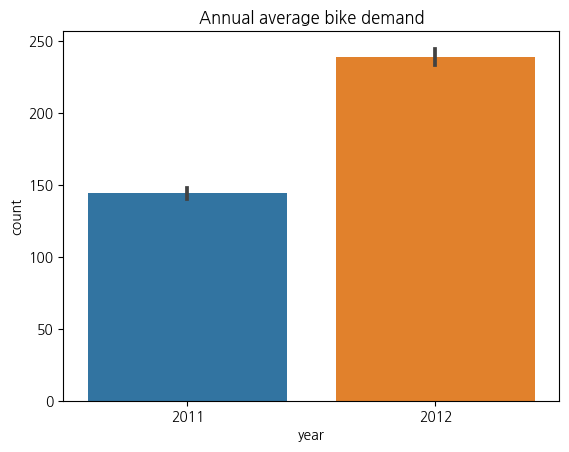

In [14]:
sns.barplot(x='year', y='count', data=train)
plt.title('Annual average bike demand')
plt.show()

2012년에 2011년도 비교해 자전거 대여수가 크게 증가했음을 알 수 있다.

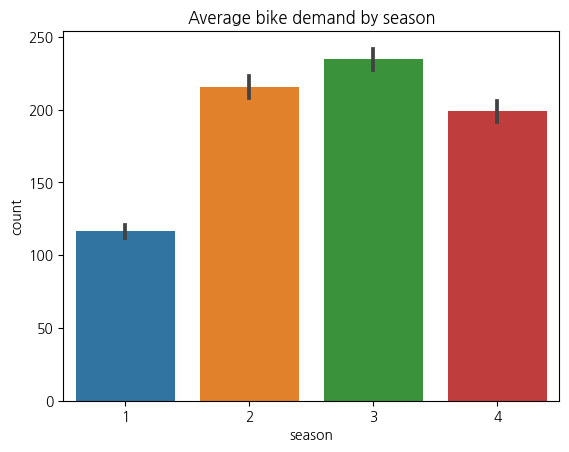

In [15]:
sns.barplot(x='season', y='count', data=train)
plt.title('Average bike demand by season')
plt.show()

계절이 가을(3)일 때, 가장 자전거 대여수를 기록했으며 반면 계절이 봄(1)일 때 가장 적은 대여수를 보였다. 그런데 겨울(4)일 때보다 봄(1)이 대여수가 적다는 것은 이해하기 여렵다.

In [16]:
# Find out which months are included for each season
print(train[train['season']==1].month.unique())
print(train[train['season']==2].month.unique())
print(train[train['season']==3].month.unique())
print(train[train['season']==4].month.unique())

[1 2 3]
[4 5 6]
[7 8 9]
[10 11 12]


확인해 본 결과 시즌1에 추운 시기인 1, 2월이 포함되어 있어 시즌1의 자전거 대여수가 적었음을 알 수 있다.

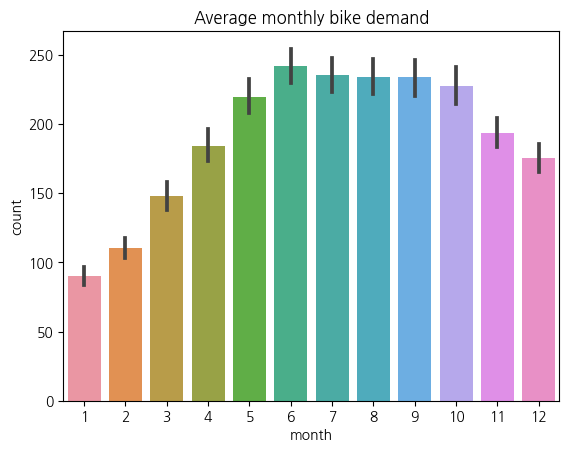

In [17]:
sns.barplot(x='month', y='count', data=train)
plt.title('Average monthly bike demand')
plt.show()

월별 대여수 플롯에도 패턴이 확연히 보인다. 예상해 볼 수 있듯이 추운 시기인 1, 2, 11, 12월에는 대여수가 줄어들고 더운지는 시기인 3월에서 10월까지는 대여수가 늘어나는 경향이 있다.

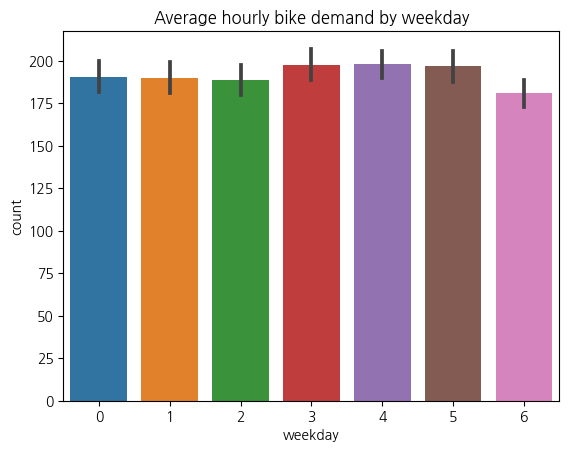

In [18]:
sns.barplot(x='weekday', y='count', data=train)
plt.title('Average hourly bike demand by weekday')
plt.show()

요일별 플롯에도 패턴이 있다고 볼 수 있는데 월요일(0)에서 수요일(2) 그리고 일요일(6)에는 다소 자전거 대수가 많고 목요일(3)에서 토요일(5)까지는 대여수가 적다.

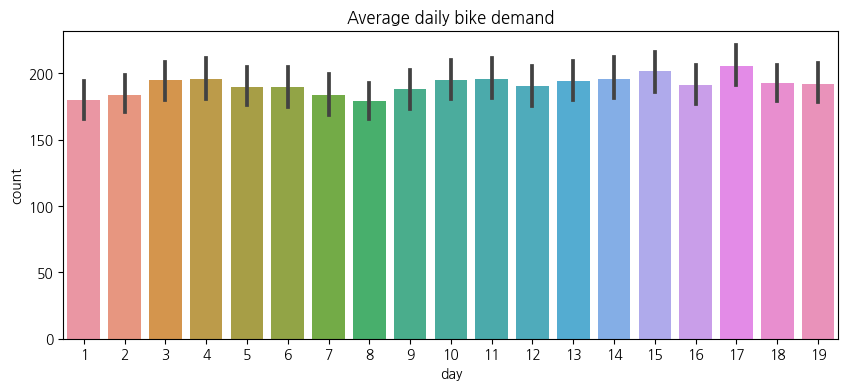

In [19]:
f2 = plt.figure(figsize=(10, 4))
sns.barplot(x=train['day'], y=train['count'])
plt.title('Average daily bike demand')
plt.show()

주어진 플롯과 데이터만으로는 일자별 바이크 대여수에 어떤 패턴이 있다고 보기에는 어려워 보인다.

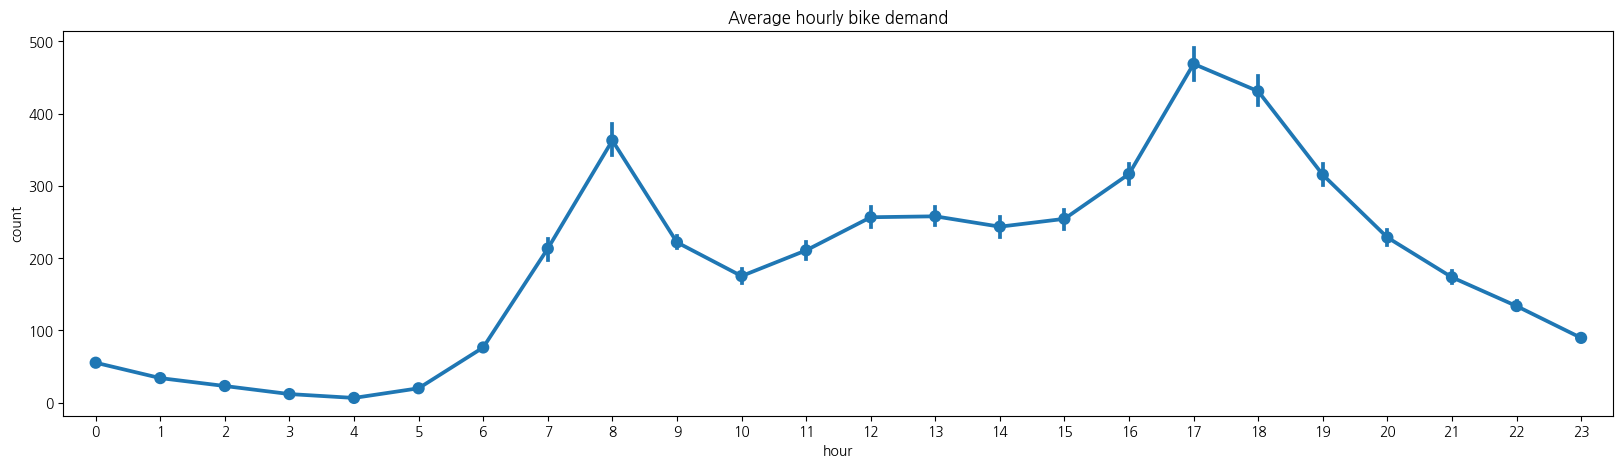

In [20]:
f1 = plt.figure(figsize=(20, 5))
sns.pointplot(x='hour', y='count', data=train)
plt.title('Average hourly bike demand')
plt.show()

시간별 대여수에는 확연한 패턴이 보인다. 이른 새벽에는 대여수가 적다가 출근시간을 기점으로 픽크를 치고 다시 퇴근시간에서 한번 더 픽크를 친 후 감소한다.

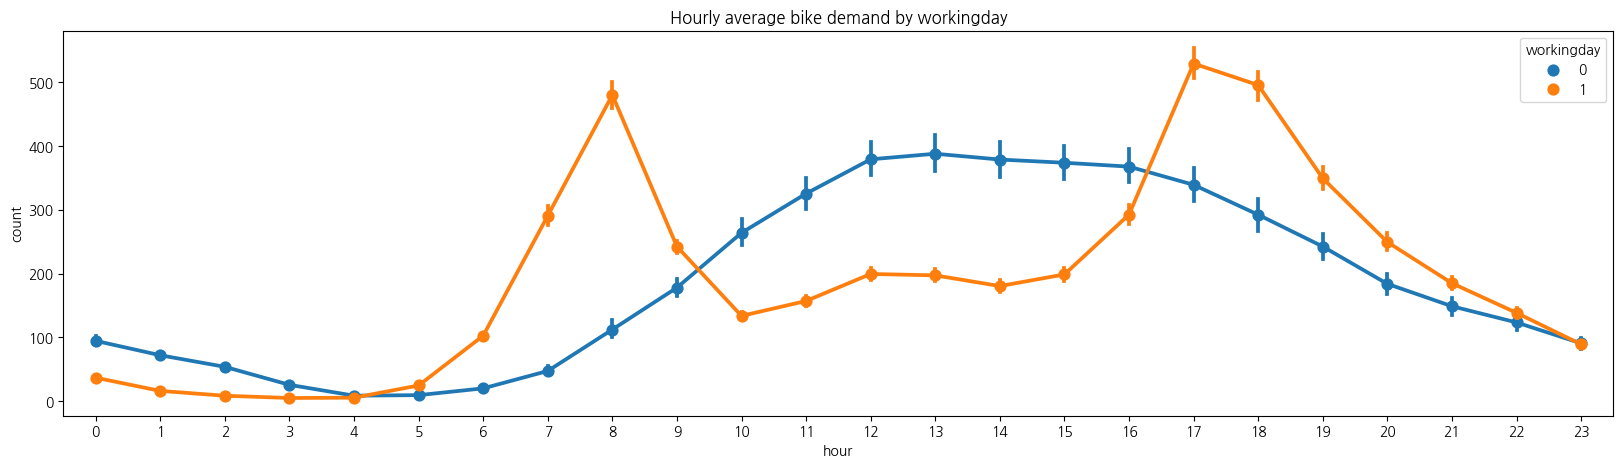

In [21]:
plt.figure(figsize=(20,5))
sns.pointplot(x='hour', y='count', data=train, hue='workingday')
plt.title('Hourly average bike demand by workingday')
plt.show()

위의 시간별 자전거 대여수 플롯을 workingday(1)와 non-workingday(0)으로 구분해 보면 둘간의 차이점을 보면 시간별 흐름에 따른 증감은 비슷하나 workingday는 non-woringday에 비해 출퇴근시간의 픽크가 있다는데 차이가 있다. 

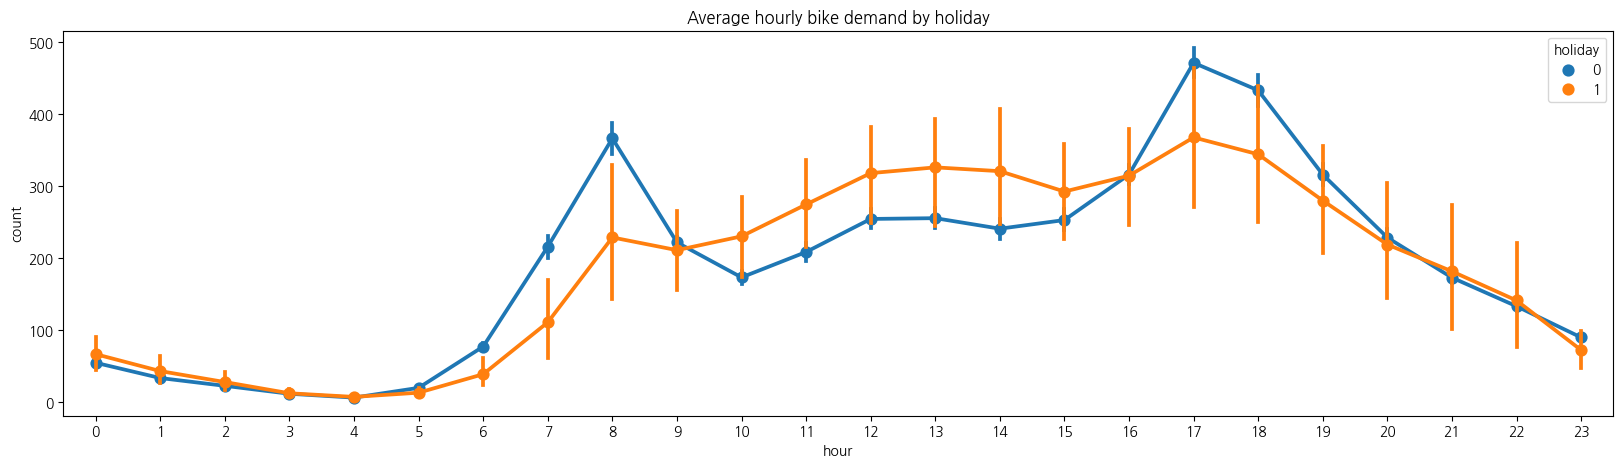

In [22]:
plt.figure(figsize=(20,5))
sns.pointplot(x='hour', y='count', data=train, hue='holiday')
plt.title('Average hourly bike demand by holiday')
plt.show()

holiday에 따른 시간별 자전거 대여수도 위의 플롯과 비슷한 흐름을 보인다.

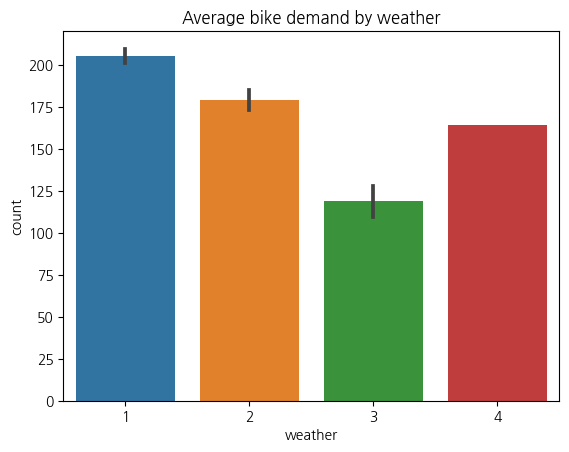

In [23]:
sns.barplot(x='weather', y='count', data=train)
plt.title('Average bike demand by weather')
plt.show()

날씨가 좋을 때(1, 2), 자전거 대여수가 높은 경향이다. 그런데, 날씨가 가장 안좋을 때(4)가 날씨(3)보다 높은 것이 잘 이해가 가지 않는다. 이에 대한 설명은 좀더 많은 데이터와 정보가 필요할 듯 보인다.

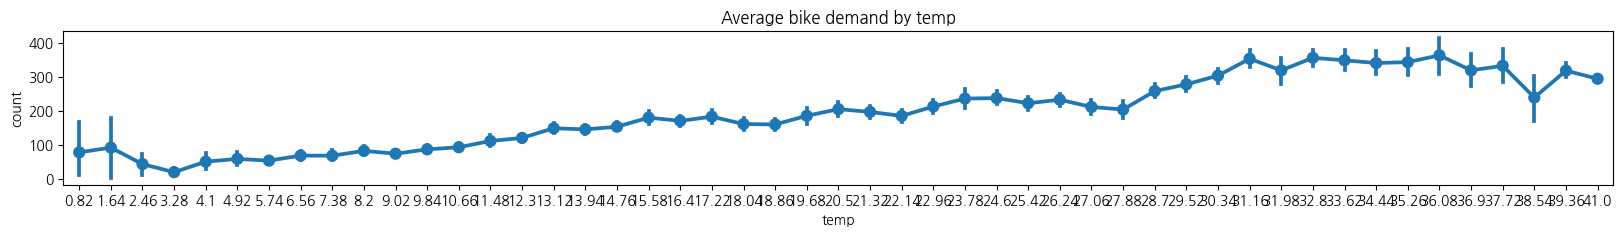

In [24]:
plt.figure(figsize=(20,2))
sns.pointplot(x='temp', y='count', data=train)
plt.title('Average bike demand by temp')
plt.show()

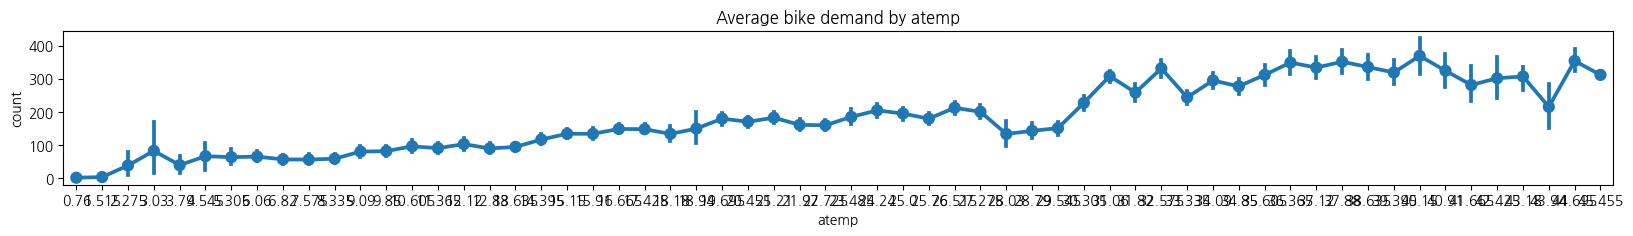

In [25]:
plt.figure(figsize=(20,2))
sns.pointplot(x='atemp', y='count', data=train)
plt.title('Average bike demand by atemp')
plt.show()

기온과 체감기온 둘다 비슷한 경향이 보이는데 기온이 오를수록 자전거 대여수가 증가하는 패턴을 보인다.

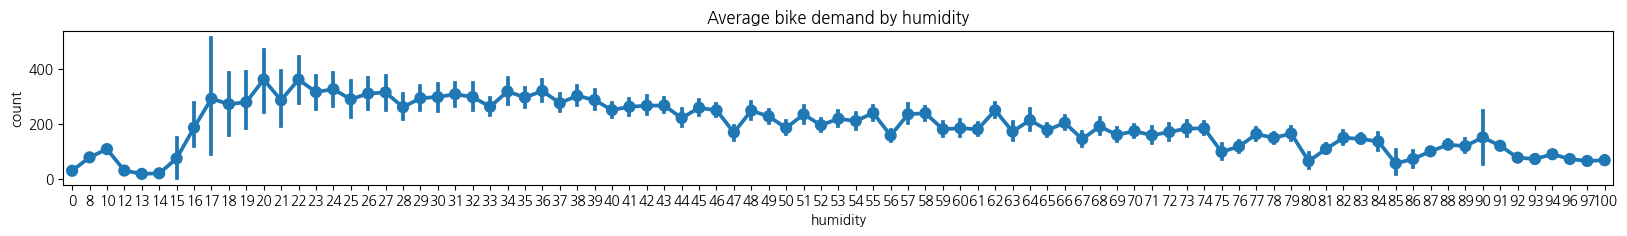

In [26]:
plt.figure(figsize=(20,2))
sns.pointplot(x='humidity', y='count', data=train)
plt.title('Average bike demand by humidity')
plt.show()

습도는 어는 시점까지 오를 때까지는 자전거 대여수가 늘어나지만 그 기점을 지나고서는 천천히 감소하는 경향을 보인다.

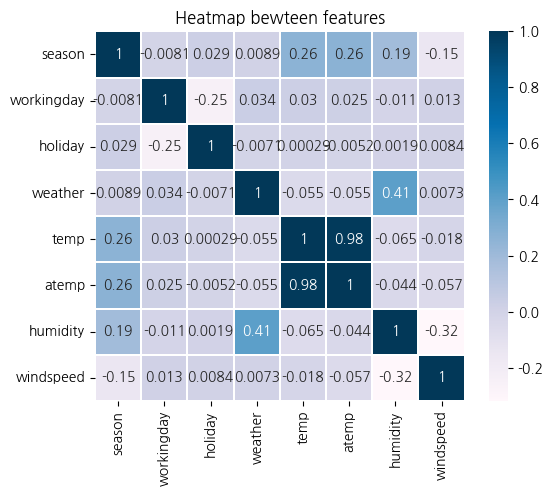

In [27]:
corr_data = train[['datetime', 'season', 'workingday', 'holiday', 'weather', 'temp',
              'atemp', 'humidity', 'windspeed']]
sns.heatmap(corr_data.corr(), cmap=plt.cm.PuBu, linewidth=0.1,
            annot=True, square=True)
plt.title('Heatmap bewteen features')
plt.show()

temp와 atemp의 상관관계가 매우 높아 다중공선성이 의심, temp 변수 하나만 사용할 것이다.

More to explore about multicollinearity:
- Korean-written: https://velog.io/@jkl133/다중공선성과-MLDL-problems
- English-written: https://medium.com/future-vision/collinearity-what-it-means-why-its-bad-and-how-does-it-affect-other-models-94e1db984168

In [28]:
# atemp 열을 삭제한다.
train.drop('atemp', axis=1, inplace=True)
test.drop('atemp', axis=1, inplace=True)

이어서 풍속과 자전거 대여수간의 관계를 살펴보자.

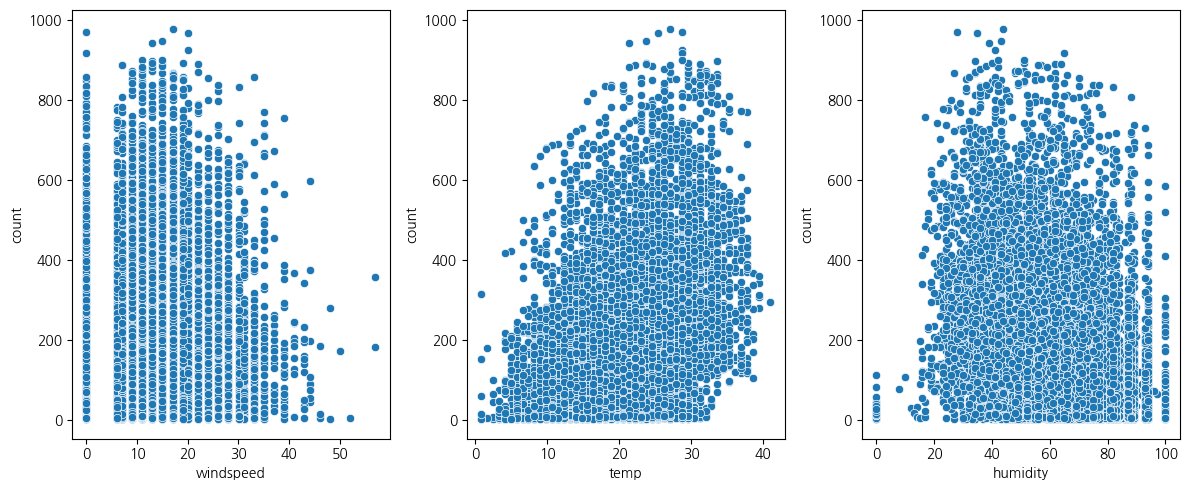

In [29]:
plt.figure(figsize=(12,5))

plt.subplot(131)
sns.scatterplot(x='windspeed', y='count', data=train)

plt.subplot(132)
sns.scatterplot(x='temp', y='count', data=train)

plt.subplot(133)
sns.scatterplot(x='humidity', y='count', data=train)

plt.tight_layout()
plt.show()

In [30]:
len(train[train.windspeed == 0])

1313

풍속이 0인 행이 1313개가 있다. 풍속이 0인 상황은 현실적으로 있을 수 없는 상황으로 풍속 0을 대체할 만한 값을 찾기 위해 랜덤포레스트 방법을 사용한다.

## 4. Feature Engineering

데이터의 왜도와 첨도를 살펴보고 조절, IQR방법으로 이상치를 제거하고 Windspeed 이상치(0인 값들)에 대한 feature engineering 진행할 것이다

### 4.1 Removing outliers

우선 연속형 변수의 box plot을 보고 이상치를 살펴 본다

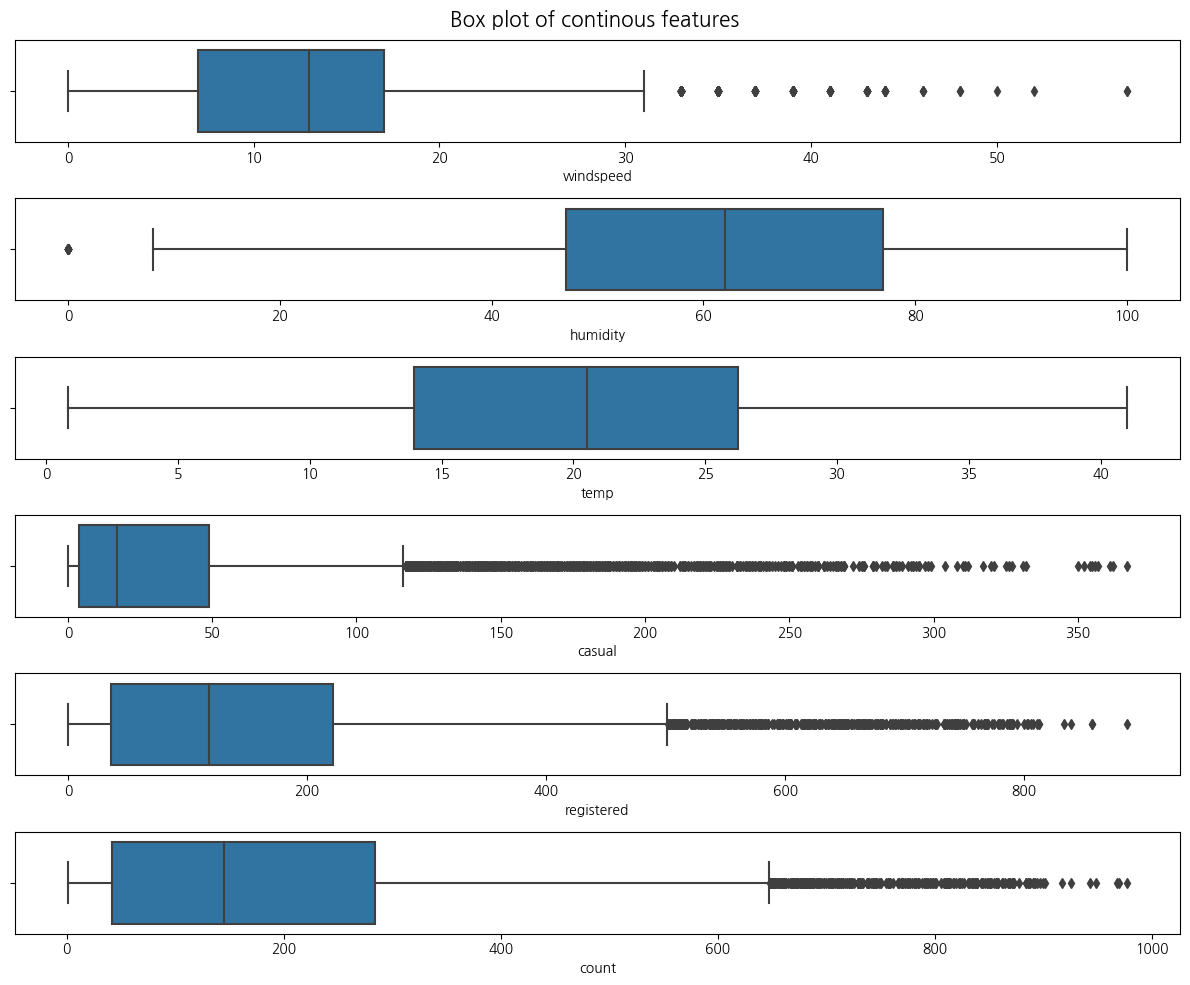

In [31]:
plt.figure(figsize=(12,10))

plt.subplot(611)
sns.boxplot(x='windspeed', data=train)

plt.subplot(612)
sns.boxplot(x='humidity', data=train)

plt.subplot(613)
sns.boxplot(x='temp', data=train)

plt.subplot(614)
sns.boxplot(x='casual', data=train)

plt.subplot(615)
sns.boxplot(x='registered', data=train)

plt.subplot(616)
sns.boxplot(x='count', data=train)

plt.suptitle('Box plot of continous features', size=15, weight=3)
plt.tight_layout()
plt.show()

In [32]:
# IQR 방법을 사용한다.
features1 = ['windspeed', 'humidity', 'temp', 'casual', 'registered', 'count']

for i in features1:
    Q1 = train[i].quantile(0.25)
    Q3 = train[i].quantile(0.75)
    IQR = Q3 - Q1
    train = train[train[i] < Q3 + 1.5 * IQR]
    train = train[train[i] > Q1 - 1.5 * IQR]
    train = train.reset_index(drop=True)
    
train

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0000,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0000,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0000,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0000,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0000,0,1,1,2011,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9359,2012-12-19 19:00:00,4,0,1,1,15.58,50,26.0027,7,329,336,2012,12,19,19,2
9360,2012-12-19 20:00:00,4,0,1,1,14.76,57,15.0013,10,231,241,2012,12,19,20,2
9361,2012-12-19 21:00:00,4,0,1,1,13.94,61,15.0013,4,164,168,2012,12,19,21,2
9362,2012-12-19 22:00:00,4,0,1,1,13.94,61,6.0032,12,117,129,2012,12,19,22,2


In [33]:
train.shape

(9364, 16)

### 4.2 Dealing with Windspeed = 0

In [34]:
# windspeed의 결측값(widspeed=0)을 RandomForest으로 예측된 값으로 대체한다
import sklearn

from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    wind0 = data[data['windspeed'] == 0]
    windnot0 = data[data['windspeed'] != 0]
    
    #windspeed는 날씨변수이기 때문에 날씨변수를 이용해서 windspeed를 예측한다
    col = ['season', 'day', 'weather', 'temp', 'humidity']
    windnot0['windspeed'] = windnot0['windspeed'].astype('str')
    
    rf = RandomForestClassifier()
    # windspeed가 0이 아닌 컬럼으로 fit 해준다
    rf.fit(windnot0[col], windnot0['windspeed'])
    
    
    # windspeed가 0인 부분을 예측
    pred_wind0 = rf.predict(X=wind0[col])
    
    # wind0의 windspeed 값을 pred_win)으로 바꿔주고
    wind0['windspeed'] = pred_wind0
    
    
    # windnot0와 wind0을 합쳐준다
    data = windnot0.append(wind0)
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

train = predict_windspeed(train)
test = predict_windspeed(test)

/var/folders/_n/d87898yn05g63lkk2gtbrwpw0000gn/T/ipykernel_1592/4110383116.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windnot0['windspeed'] = windnot0['windspeed'].astype('str')
/var/folders/_n/d87898yn05g63lkk2gtbrwpw0000gn/T/ipykernel_1592/4110383116.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind0['windspeed'] = pred_wind0
/var/folders/_n/d87898yn05g63lkk2gtbrwpw0000gn/T/ipykernel_1592/4110383116.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pand

In [35]:
len(train[train['windspeed'] == 0])

0

랜덤포레스트 방법을 적용한 후 풍속 0인 값이 더이상 없음을 확인할 수 있다.

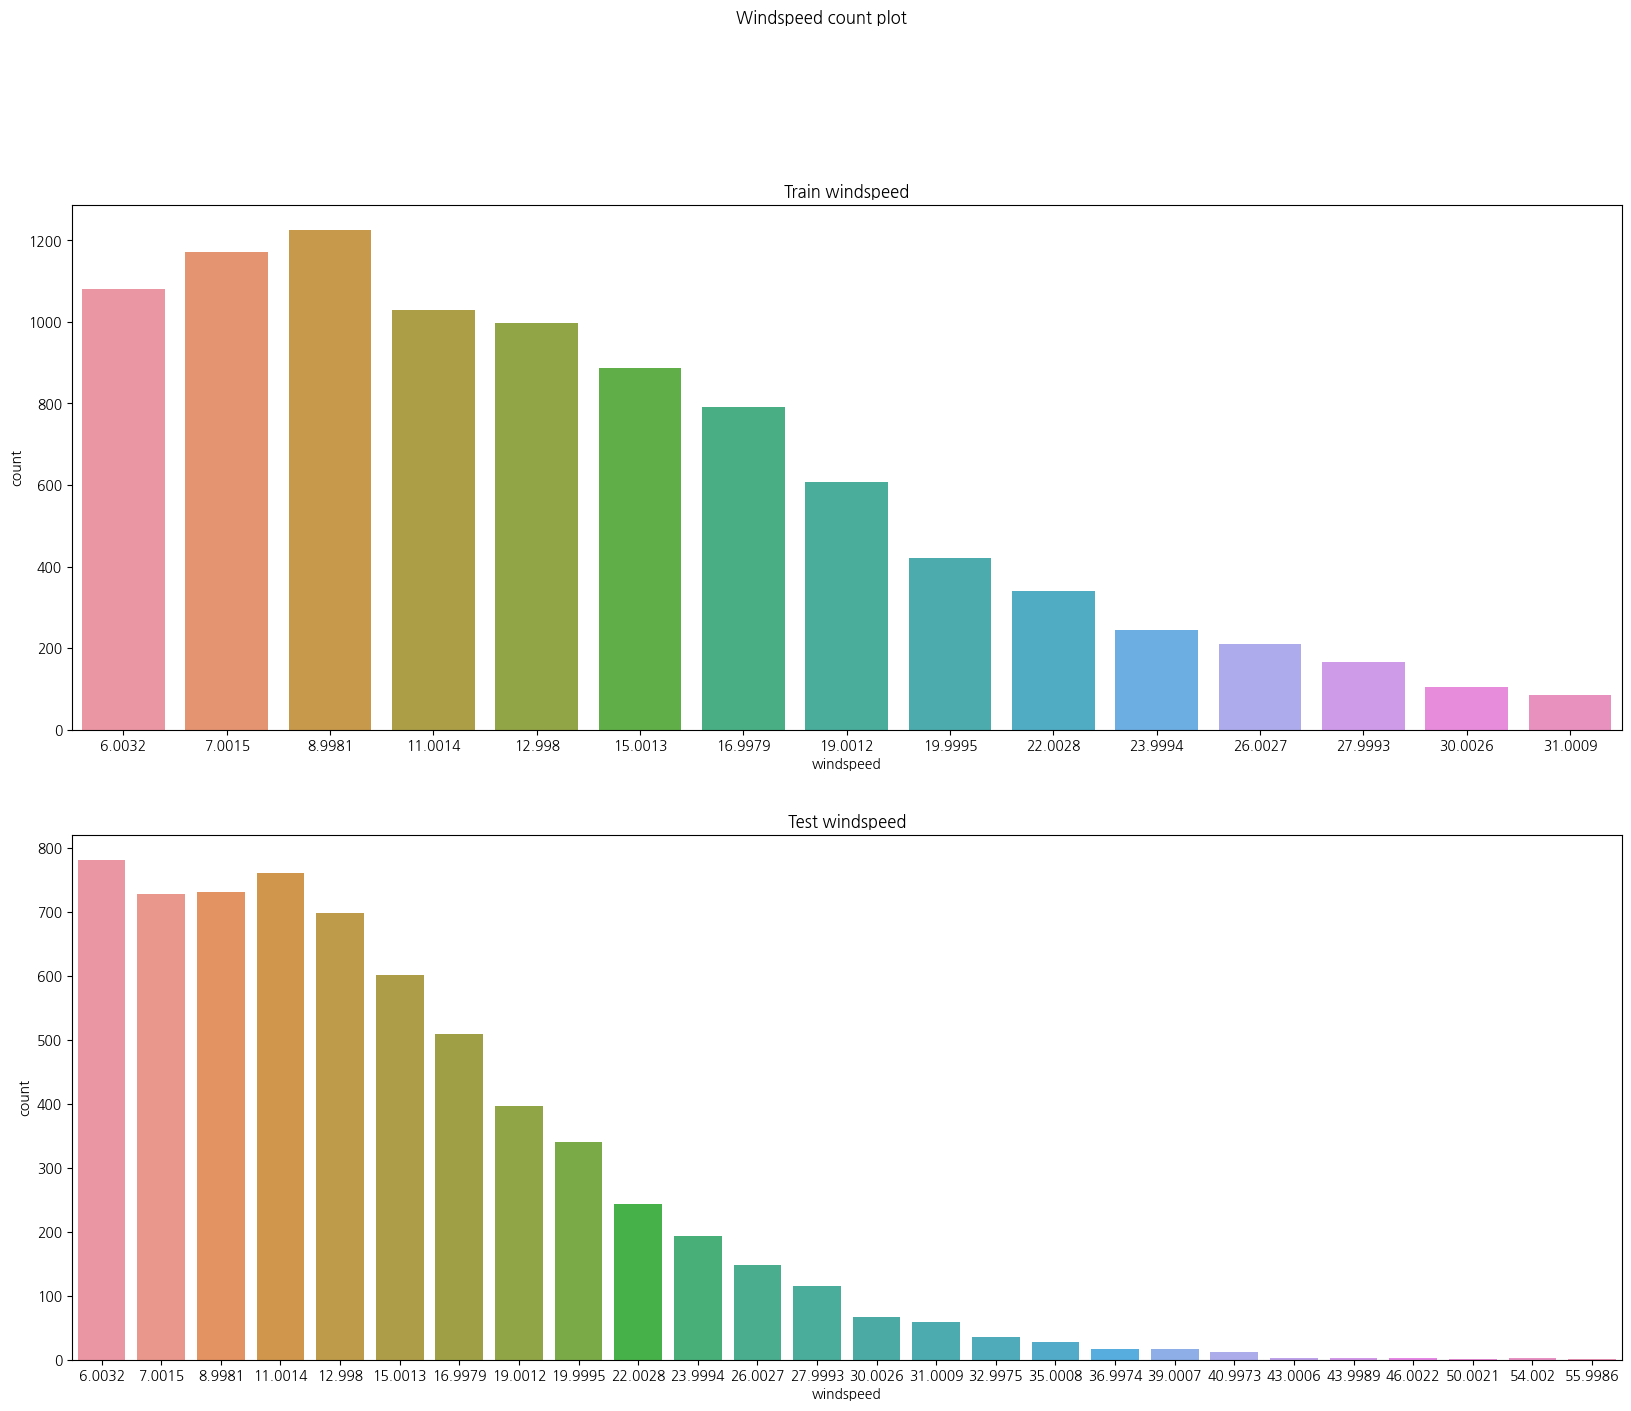

In [36]:
# Plot windspeed with countplot for train and test data
plt.figure(figsize=(20,15))

plt.subplot(211)
sns.countplot(x='windspeed', data=train)
plt.title('Train windspeed')

plt.subplot(212)
sns.countplot(x='windspeed', data=test)
plt.title('Test windspeed')

plt.suptitle('Windspeed count plot', y=1.01)
plt.show()

### 4.3 Skewness & Kurtosis of Bike Rental Counts

<Figure size 1000x600 with 0 Axes>

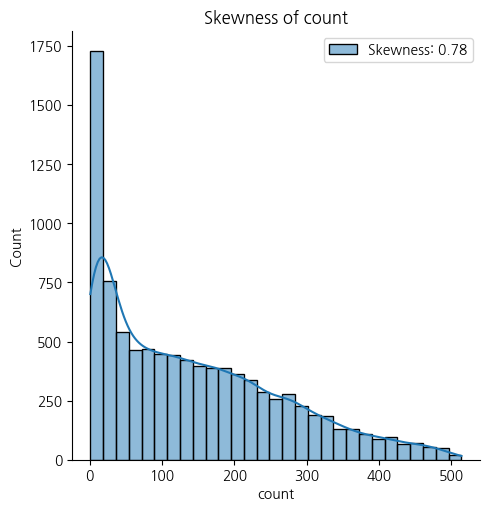

skewness(왜도): 0.78
kurt(첨도): -0.24


In [37]:
# count 열의 왜도와 첨도를 구해보자.

plt.figure(figsize=(10, 6))

sns.displot(train['count'], kde=True, label=
             'Skewness: {:.2f}'.format(train['count'].skew()))
plt.title('Skewness of count')
plt.legend(loc=0)
plt.show()
print('skewness(왜도): %.2f' % train['count'].skew())
print('kurt(첨도): %.2f' % train['count'].kurt())

<Figure size 1000x600 with 0 Axes>

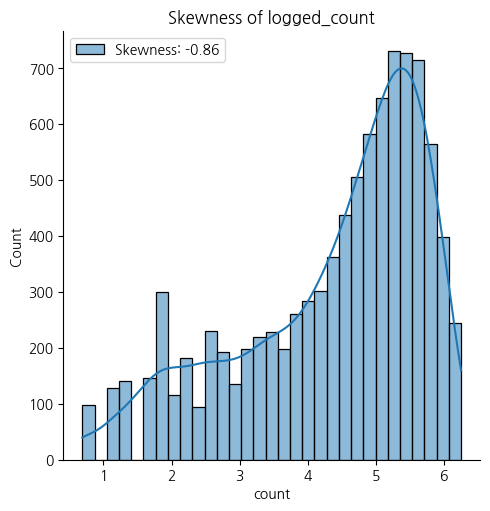

skewness(왜도): -0.86
kurt(첨도): -0.23


In [38]:
# Count가 0에 굉장희 많이 치우쳐져 있는 것을 확인할 수 있다. 따라서 log scaling을 통해 정규 분포화 시켜준다.
# 주의할 점은 count에 log를 취해주었으니 마지막 나온 결과값에 다시 exp()를 취해줘야 원래 원하던 값을 얻을 수 있다는 것이다.
# log()함수는 log1p()함수를 써서 언더/오버플로 오류를 줄인다. log1p()는 1+log()값으로 log 변환값에 1을 더해 이러한 문제를 해결.
# log1p()는 expm1()함수로 원래의 스케일로 복원한다

logged_count = np.log1p(train['count'])

plt.figure(figsize=(10, 6))

sns.displot(logged_count, kde=True, label=
             'Skewness: {:.2f}'.format(logged_count.skew()))
plt.title('Skewness of logged_count')
plt.legend(loc=0)
plt.show()
print('skewness(왜도): %.2f' % logged_count.skew())
print('kurt(첨도): %.2f' % logged_count.kurt())

원하는 정규분포는 아니지만 왜곡정도가 많이 향상되었다. 이를 이용해 다음 5장에서 Linear Regression 모델을 학습 후 평가 수행한다.

In [39]:
# Log the count column
train['count'] = np.log1p(train['count'])
train.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 05:00:00,1,0,0,2,9.84,75,6.0032,0,1,0.693147,2011,1,1,5,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,76,16.9979,12,24,3.610918,2011,1,1,10,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,81,19.0012,26,30,4.043051,2011,1,1,11,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,77,19.0012,29,55,4.442651,2011,1,1,12,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,72,19.9995,47,47,4.553877,2011,1,1,13,5


year, month, day, hour 열이 추가되었으므로, datetime 열은 삭제한다. 또한 casual은 비등록 대여자, registered은 등록된 사용자로 casual+registered = count이므로 casual과 registered은 따로 필요하지 않음. 오히려 상관관계가 높아 에측성능을 저해야 우려가 있어 이 두열도 삭제한다.

In [40]:
train = train.drop(['datetime', 'casual', 'registered'], axis=1)
test = test.drop('datetime', axis=1)

# 5. Selecting a Model

다양한 회귀모델을 데이터 세트에 적용해 예측 성능을 측정한다. 캐글에서 요구한 성능 평가 방법은 RMSLE(Root Mean Squared Logarithmic Error)이다. 즉, 오류값의 로그에 대한 RMSE이다. 사이킷런은 RMSLE을 제공하지 않아 RMSLE을 수행하는 평가 함수를 직접 만들어 본다 

In [41]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

### 5.1 Linear Regression Methods

In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['count'], axis=1), train['count'], test_size=0.3)

In [43]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('RMSLE:', rmsle(y_test_exp, pred_exp))

RMSLE: 0.9978671247747144


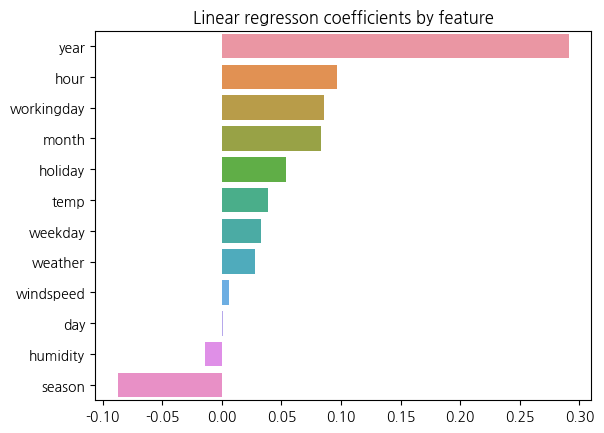

In [44]:
# 선형회귀 모델의 회귀 계수를 계산해 보자.

coef= pd.Series(lr_reg.coef_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=coef.values, y=coef.index)
plt.title('Linear regresson coefficients by feature')
plt.show()

year 변수의 회귀 계수가 독보적으로 크다. year는 2011, 2012 두개의 값으로 되어 있는데 여기에 자전거 대여수가 크게 결정된다는 것은 납득하기 힘들다. year 회귀 계수가 큰 것은 20111, 2012 숫자로 되어 있기 때문. 따라 one-hot encoding을 이용해 카테고리 값으로 변형해야 한다

In [45]:
# 판다스의 get_dummies()을 이용해서 year, month, day, hour, weekday, season, holiday, workingday, weather의 열도 모두 one-hot encoding 한다.

train = pd.get_dummies(train, columns=[
    'year', 'month','day','hour','weekday', 'season', 'holiday', 'workingday', 'weather'])
test = pd.get_dummies(test, columns=[
    'year', 'month','day','hour', 'weekday', 'season', 'holiday', 'workingday', 'weather'])

In [46]:
print(train.shape)
print(test.shape)

(9364, 80)
(6493, 72)


train과 test의 shape을 맞춰주기 위해 align을 사용한다. 
- Reference: https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding

In [47]:
train, test = train.align(test, join='left', axis=1)
test = test.drop('count', axis=1)

In [48]:
print(train.shape)
print(test.shape)

(9364, 80)
(6493, 79)


In [49]:
# 테스트 사이즈를 0.3으로 잡는다.
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['count'], axis=1), train['count'], test_size=0.3)

In [50]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
print('LinearRegression RMSLE:', rmsle(y_test_exp, pred_exp))

LinearRegression RMSLE: 0.5835697456144544


In [51]:
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
r_pred = ridge_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
r_pred_exp = np.expm1(r_pred)
print('Ridge RMSLE:', rmsle(y_test_exp, r_pred_exp))

Ridge RMSLE: 0.583806314128547


In [52]:
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X_train, y_train)
l_pred = lasso_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
l_pred_exp = np.expm1(l_pred)
print('Lasso RMSLE:', rmsle(y_test_exp, l_pred_exp))

Lasso RMSLE: 0.6256772298478678


원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상되었다. 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피쳐를 다시 시각한다. 원-핫 인코딩으로 피쳐가 늘어났으므로 회귀 계수 상위 25개 피쳐를 추출한다.

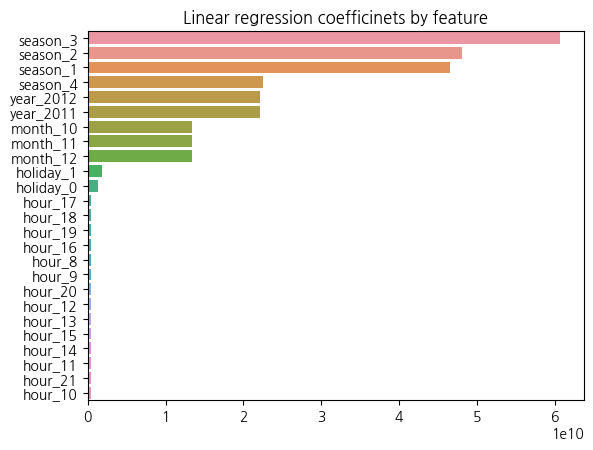

In [53]:
coef = pd.Series(lr_reg.coef_, index=X_train.columns).sort_values(ascending=False)[:25]
sns.barplot(x=coef.values, y=coef.index)
plt.title('Linear regression coefficinets by feature')
plt.show()

### 5.2 Tree Based Methods

이번에는 회귀 트리를 이용해 회귀 예측을 한다. 앞에서 적용한 Target 값의 로그 변환된 값과 원-핫 인코딩된 피쳐 세트를 그대로 이용해 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가한다.

In [54]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [55]:
rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
rf_pred_exp = np.expm1(rf_pred)
print('RandomForestRegressor RMSLE: ', rmsle(y_test_exp, rf_pred_exp))

RandomForestRegressor RMSLE:  0.33126569766176045


In [56]:
gb_reg = GradientBoostingRegressor(n_estimators=500)
gb_reg.fit(X_train, y_train)
gb_pred = gb_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
gb_pred_exp = np.expm1(gb_pred)
print('GradientBoostingRegressor RMSLE: ', rmsle(y_test_exp, gb_pred_exp))

GradientBoostingRegressor RMSLE:  0.33526169663856786


In [57]:
xgb_reg = XGBRegressor(n_estimators=500)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
xgb_pred_exp = np.expm1(xgb_pred)
print('XGBRegressor RMSLE: ', rmsle(y_test_exp, xgb_pred_exp))

XGBRegressor RMSLE:  0.32414671717910043


In [58]:
lgbm_reg = LGBMRegressor(n_estimators=500)
lgbm_reg.fit(X_train, y_train)
lgbm_pred = lgbm_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
lgbm_pred_exp = np.expm1(lgbm_pred)
print('LBGMRegressor RMSLE: ', rmsle(y_test_exp, lgbm_pred_exp))

LBGMRegressor RMSLE:  0.3001590531259859


트리기반의 모델들이 앞의 선형 회귀보다 예측 성능이 향상된 것을 알 수 있다. 단, 이것은 회귀 트리가 선형 회귀보다 낫다는 뜻은 아니며 데이터 세트에 따라 결과는 달라질 수 있음에 유의한다.

## 6. Prediction and Submission

마지막으로 가장 좋은 결과를 낸 모델을 선택하고 그 결과값에 expm1() 함수를 적용한다. 

In [59]:
X_train = train.drop('count', axis=1)
y_train = train['count']
X_test = test

In [60]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(9364, 79)
(9364,)
(6493, 79)


In [61]:
lgbm_reg = LGBMRegressor(n_estimators=500)
lgbm_reg.fit(X_train, y_train)
lgbm_pred = lgbm_reg.predict(X_test)

pred_exp = np.expm1(lgbm_pred)

In [62]:
submission = pd.read_csv('sampleSubmission.csv')
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [63]:
submission['count'] = pred_exp
submission

,datetime,count
0,2011-01-20 00:00:00,10.981245
1,2011-01-20 01:00:00,2.878536
2,2011-01-20 02:00:00,1.916502
3,2011-01-20 03:00:00,5.756087
4,2011-01-20 04:00:00,38.168792
...,...,...
6488,2012-12-31 19:00:00,117.088676
6489,2012-12-31 20:00:00,119.089314
6490,2012-12-31 21:00:00,254.988938
6491,2012-12-31 22:00:00,64.033045


In [64]:
submission.to_csv('submission', index=False)